# Analyse des dommages et des tirs en Isère
Auteur : Daniel Thonon

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import numpy as np
import datetime
# Apply the default theme
sns.set_theme()

In [16]:
data_url = "https://raw.githubusercontent.com/dthonon/pna_loup_suivi/main/data/"
# data_url = "../data/"
# Lecture des départements
constats = pd.read_csv(
    data_url + "bilan_constat_loup_38.csv",
    sep=",",
    header=0,
    names=[
        "Commune",
        "Cercle",
        "Secteur",
        "Lieu-dit",
        "Date attaque",
        "Num semaine",
        "Animaux concernés",
        "Victimes constatées",
        "Taille troupeau ou lot",
        "Conclusion expertise",
        "Indemnisation",
        "Protocole",
        "Num AP tir",
    ],
    usecols=[
        "Commune",
        "Cercle",
        "Secteur",
        "Lieu-dit",
        "Date attaque",
        "Animaux concernés",
        "Victimes constatées",
        "Taille troupeau ou lot",
        "Conclusion expertise",
        "Indemnisation",
    ],
    parse_dates=["Date attaque"],
    dayfirst=True
)
constats["Année"] = pd.to_datetime(constats["Date attaque"]).dt.year
constats


,Commune,Cercle,Secteur,Lieu-dit,Date attaque,Animaux concernés,Victimes constatées,Taille troupeau ou lot,Conclusion expertise,Indemnisation,Année
0,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-04-14,Ovin,8,40,Loup,Oui,2017
1,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-04-16,Ovin,7,40,Loup,Oui,2017
2,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-04-17,Ovin,2,40,Loup,Oui,2017
3,VATILIEU,2,Bas Grésivaudan,Charbonnière,2017-05-04,Ovin,3,40,Loup,Oui,2017
4,VATILIEU,1,Bas Grésivaudan,Charbonnière,2017-05-17,Ovin,1,5,Loup,Oui,2017
...,...,...,...,...,...,...,...,...,...,...,...
2128,VILLARD-SAINT-CHRISTOPHE,1,Tabor,Grand Serre,2023-07-26,Ovin,1,NaN,Indéterminé,Attente transmission constat,2023
2129,VILLARD-SAINT-CHRISTOPHE,1,Tabor,Le Bois Rond,2023-07-08,Bovin,1,90,Indéterminé,Non - loup exclu,2023
2130,VIRIVILLE,1,Bièvre,Route des Chambarrans,2023-04-12,Veau naissant,1,25,Loup typé,Oui,2023
2131,VIRIVILLE,1,Bièvre,Chambarans,2023-04-04,Veau,1,50,Loup non exclu,Oui,2023


## Evolution des statuts d'indemnisation

In [17]:
pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Indemnisation",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    margins=True,
    margins_name="Total",
)


Année,2013,2017,2018,2019,2020,2021,2022,2023,Total
Indemnisation,,,,,,,,,
Attente transmission constat,0,0,0,0,0,3,4,11,18
En cours d'instruction,0,53,0,72,1,0,0,3,129
Non - loup exclu,0,17,23,34,16,18,12,9,129
Non indemnisable,0,6,31,7,56,49,85,31,265
Oui,2,639,700,1055,1190,963,1005,357,5911
Total,2,715,754,1168,1263,1033,1106,411,6452


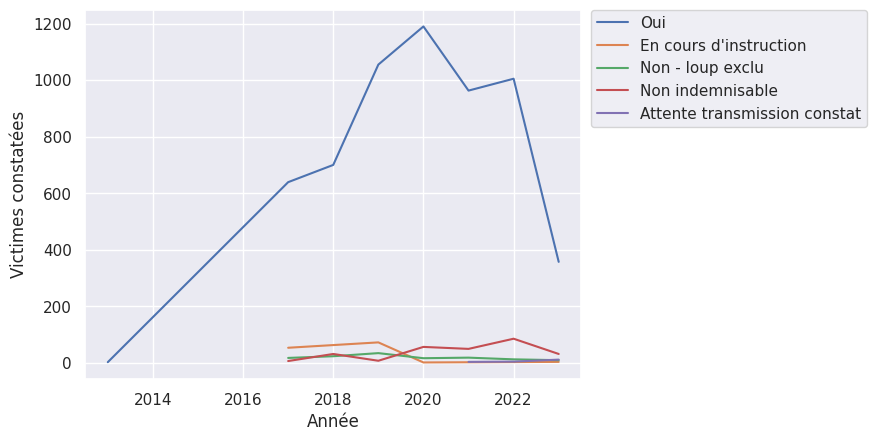

In [18]:
par_indemnisation_l = constats.groupby(["Année", "Indemnisation"]).sum(numeric_only=True)
sns.lineplot(data=par_indemnisation_l, x="Année", y="Victimes constatées", hue="Indemnisation");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

Année,2023
Indemnisation,
Attente transmission constat,11
En cours d'instruction,3
Non - loup exclu,9
Non indemnisable,31
Oui,357


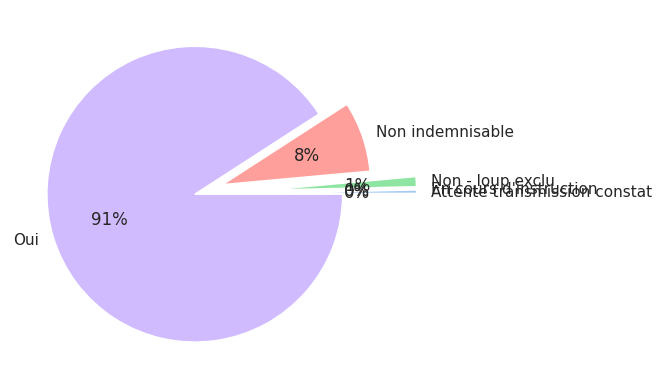

In [20]:
par_indemnisation = pd.pivot_table(
    constats,
    values="Victimes constatées",
    index="Indemnisation",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
)
data = list(par_indemnisation[[2022]].values.flat)
labels = par_indemnisation[[2022]].index.values
colors = sns.color_palette("pastel")[0:7]
explode = (0.5, 0.5, 0.5, 0.2, 0)
plt.pie(data, labels=labels, colors=colors, explode=explode, autopct="%1.0f%%", labeldistance=1.1)
par_indemnisation[[2023]]


In [21]:
constats_o = constats.query("Indemnisation == 'Oui'")

## Evolution par type d'animal de rente prédaté

In [22]:
par_animal = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Animaux concernés",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    # margins=True,
    # margins_name="Total"
)
par_animal

Année,2013,2017,2018,2019,2020,2021,2022,2023
Animaux concernés,,,,,,,,
Anon naissant,0,1,0,0,0,0,0,0
Autre,0,0,0,0,3,0,2,1
Bovin,0,4,17,17,28,13,26,27
Canin,0,0,1,0,4,2,3,4
Caprin,2,4,4,14,33,46,40,8
Equin,0,0,2,3,0,1,2,1
Ovin,0,622,667,1001,1107,854,888,299
Veau,0,4,0,11,8,33,29,10
Veau naissant,0,4,9,9,7,14,15,7


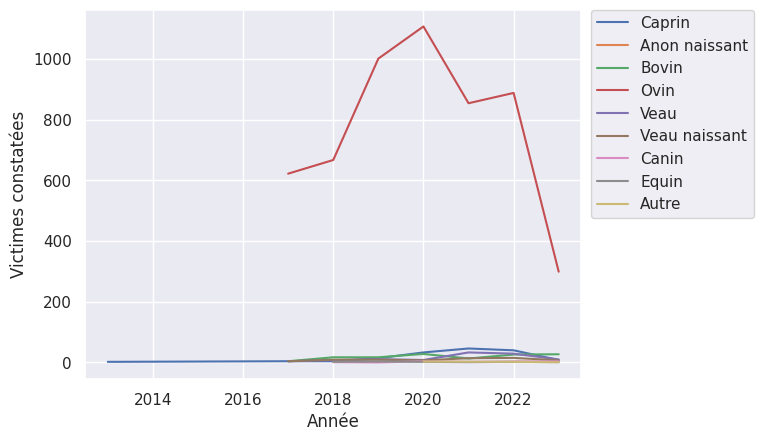

In [23]:
par_animal_l = constats_o.groupby(["Année", "Animaux concernés"]).sum(numeric_only=True)
sns.lineplot(data=par_animal_l, x="Année", y="Victimes constatées", hue="Animaux concernés");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);


## Evolution par secteur

Le tableau suivant résume les dommages indemnisés par secteur.

In [24]:
par_secteur = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Secteur",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    margins=True,
    margins_name="Total"
)
par_secteur

Année,2013,2017,2018,2019,2020,2021,2022,2023,Total
Secteur,,,,,,,,,
Balmes Viennoises,0,0,0,0,0,0,0,2,2
Bas Drac,0,9,0,0,5,0,1,1,16
Bas Grésivaudan,0,21,1,5,37,2,3,0,69
Beaumont,2,0,14,18,35,3,27,12,111
Belledonne Centre,0,49,18,34,43,45,42,0,231
Belledonne Nord,0,18,41,18,15,14,23,19,148
Belledonne Sud,0,28,15,22,18,36,86,18,223
Bièvre,0,0,0,0,1,8,9,4,22
Chambarans,0,0,2,0,0,3,49,13,67


In [35]:
par_secteur = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Secteur",
    columns="Année",
    aggfunc="count",
    fill_value=0,
    margins=True,
    margins_name="Total"
)
par_secteur

Année,2013,2017,2018,2019,2020,2021,2022,2023,Total
Secteur,,,,,,,,,
Balmes Viennoises,0,0,0,0,0,0,0,2,2
Bas Drac,0,1,0,0,3,0,1,1,6
Bas Grésivaudan,0,5,1,3,6,2,1,0,18
Beaumont,1,0,6,11,8,2,9,8,45
Belledonne Centre,0,18,11,18,20,25,18,0,110
Belledonne Nord,0,3,10,9,7,10,9,8,56
Belledonne Sud,0,7,13,10,14,20,32,10,106
Bièvre,0,0,0,0,1,7,5,4,17
Chambarans,0,0,1,0,0,3,22,8,34


## Evolution par commune

In [25]:
par_commune = pd.pivot_table(
    constats_o,
    values="Victimes constatées",
    index="Commune",
    columns="Année",
    aggfunc=np.sum,
    fill_value=0,
    margins=True,
    margins_name="Total"
)
pd.set_option('display.max_rows', 500)
par_commune

Année,2013,2017,2018,2019,2020,2021,2022,2023,Total
Commune,,,,,,,,,
ALLEMOND,0,20,2,1,12,5,4,0,44
ALLEVARD,0,17,21,6,1,1,0,0,46
AURIS,0,9,0,3,49,4,5,0,70
AUTRANS-MÉAUDRE EN VERCORS,0,2,0,0,0,3,0,0,5
AVIGNONET,0,6,0,0,0,0,0,0,6
BESSE,0,26,2,22,13,31,19,9,122
BESSINS,0,0,0,0,0,0,4,0,4
BIOL,0,0,0,0,0,3,0,0,3
BOSSIEU,0,0,0,0,0,8,10,1,19


## Pression de prédation

In [ ]:
gis_dir = "/home/daniel/Data/SIG/ADMIN-EXPRESS/1_DONNEES_LIVRAISON_2021-11-16/ADE_3-1_SHP_LAMB93_FR/"
# departements = gpd.read_file(gis_dir + "DEPARTEMENT.shp")
communes = gpd.read_file(gis_dir + "COMMUNE.shp")

In [ ]:
communes_38 = communes.query("INSEE_DEP == '38'")[["NOM", "geometry"]]
communes_38["Commune"] = communes_38["NOM"].str.upper()
communes_38 = communes_38.drop(columns="NOM").set_index("Commune")

In [ ]:
par_commune_l = constats_o.groupby(["Année", "Commune"]).sum(numeric_only=True)

par_commune_l_2017 = par_commune_l.query("Année == 2017").reset_index(inplace=False).set_index("Commune").drop(columns="Année")
par_commune_l_2017 = communes_38.merge(
    par_commune_l_2017, left_index=True, right_index=True, how="outer"
)
par_commune_l_2018 = par_commune_l.query("Année == 2018").reset_index(inplace=False).set_index("Commune").drop(columns="Année")
par_commune_l_2018 = communes_38.merge(
    par_commune_l_2018, left_index=True, right_index=True, how="outer"
)
par_commune_l_2019 = par_commune_l.query("Année == 2019").reset_index(inplace=False).set_index("Commune").drop(columns="Année")
par_commune_l_2019 = communes_38.merge(
    par_commune_l_2019, left_index=True, right_index=True, how="outer"
)
par_commune_l_2020 = par_commune_l.query("Année == 2020").reset_index(inplace=False).set_index("Commune").drop(columns="Année")
par_commune_l_2020 = communes_38.merge(
    par_commune_l_2020, left_index=True, right_index=True, how="outer"
)
par_commune_l_2021 = par_commune_l.query("Année == 2021").reset_index(inplace=False).set_index("Commune").drop(columns="Année")
par_commune_l_2021 = communes_38.merge(
    par_commune_l_2021, left_index=True, right_index=True, how="outer"
)
par_commune_l_2022 = par_commune_l.query("Année == 2022").reset_index(inplace=False).set_index("Commune").drop(columns="Année")
par_commune_l_2022 = communes_38.merge(
    par_commune_l_2022, left_index=True, right_index=True, how="outer"
)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15,30 ));
axs[0, 0].set_axis_off()
axs[0, 0].set_title("2017")
par_commune_l_2017.plot(
    ax=axs[0, 0],
    column="Victimes constatées",
    linewidth=0.1,
    legend=True,
    #legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap='Reds',
);
axs[0, 1].set_axis_off()
axs[0, 1].set_title("2018")
par_commune_l_2018.plot(
    ax=axs[0, 1],
    column="Victimes constatées",
    linewidth=0.1,
    legend=True,
    #legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap='Reds',
);
axs[1, 0].set_axis_off()
axs[1, 0].set_title("2019")
par_commune_l_2019.plot(
    ax=axs[1, 0],
    column="Victimes constatées",
    linewidth=0.1,
    legend=True,
    #legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap='Reds',
);
axs[1, 1].set_axis_off()
axs[1, 1].set_title("2020")
par_commune_l_2020.plot(
    ax=axs[1, 1],
    column="Victimes constatées",
    linewidth=0.1,
    legend=True,
    #legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap='Reds',
);
axs[2, 0].set_axis_off()
axs[2, 0].set_title("2021")
par_commune_l_2021.plot(
    ax=axs[2, 0],
    column="Victimes constatées",
    linewidth=0.1,
    legend=True,
    #legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap='Reds',
);
axs[2, 1].set_axis_off()
axs[2, 1].set_title("2022")
par_commune_l_2022.plot(
    ax=axs[2, 1],
    column="Victimes constatées",
    linewidth=0.1,
    legend=True,
    #legend_kwds={"label": "Prédations par commune", "orientation": "horizontal"},
    missing_kwds={"color": "lightgrey"},
    cmap='Reds',
);

## Etude de certains secteurs

### Belledonne Sud

In [ ]:
constats_bs = constats_o.query("Secteur == 'Belledonne Sud' & Année > 2015")
# constats_bs.sort_values(by="Date attaque")

In [ ]:
plt.figure(figsize=(20, 8))
# ax = sns.scatterplot(data=constats_bs, x="Date attaque", y="Victimes constatées").set(title="Secteur Belledonne Sud");
ax = sns.histplot(
    data=constats_bs, x="Date attaque", binwidth=7
).set(title="Secteur Belledonne Sud", ylabel="Nombre d'attaques par semaine")
plt.axvline(x=datetime.datetime(2021, 7, 11), color="red")
plt.axvline(x=datetime.datetime(2022, 10, 13), color="red", ymax=0.5)
plt.axvline(x=datetime.datetime(2022, 12, 8), color="red", ymax=0.5)
plt.show()


### Belledonne centre

In [ ]:
constats_bc = constats_o.query("Secteur == 'Belledonne Centre' & Année > 2015")

In [ ]:
plt.figure(figsize=(20, 8))
# ax = sns.scatterplot(data=constats_bs, x="Date attaque", y="Victimes constatées").set(title="Secteur Belledonne Sud");
ax = sns.histplot(
    data=constats_bc, x="Date attaque", binwidth=7
).set(title="Secteur Belledonne Centre", ylabel="Nombre d'attaques par semaine")
plt.show()

### Belledonne Nord

In [ ]:
constats_bn = constats_o.query("Secteur == 'Belledonne Centre' & Année > 2015")

In [ ]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(
    data=constats_bn, x="Date attaque", binwidth=7
).set(title="Secteur Belledonne Nord", ylabel="Nombre d'attaques par semaine")
plt.show()

### Beaumont

In [ ]:
constats_b = constats_o.query("Secteur == 'Beaumont' & Année > 2015")
# constats_b.sort_values(by="Date attaque")

In [ ]:
plt.figure(figsize=(20, 8))
ax = sns.histplot(
    data=constats_b, x="Date attaque", binwidth=7
).set(title="Secteur Beaumont", ylabel="Nombre d'attaques par semaine")
plt.axvline(x=datetime.datetime(2022, 10, 7), color="red")
plt.show()